In [260]:
import numpy as np
import librosa
from scipy import signal
import matplotlib.pyplot as plt
import pywt
import librosa.display
import os
from os import listdir
import scipy.io as sio;
import glob
import pandas as pd
from numpy import trapz

In [261]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans


In [262]:
'''Funcion para graficar las matrices de confusion'''

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix cr',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y traza la matriz de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [263]:
df_boxcox= pd.read_csv("TabladeResultadosBoxCox.csv") #Se importa el archivo con los datos
print(df_boxcox.head(),df_boxcox.info()) # Se corrobora la información 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sumatoria PSD     5852 non-null   float64
 1   Mediana PSD       5852 non-null   float64
 2   Varianza          5852 non-null   float64
 3   Estado del ciclo  5852 non-null   object 
dtypes: float64(3), object(1)
memory usage: 183.0+ KB
   Sumatoria PSD  Mediana PSD  Varianza Estado del ciclo
0      -9.018249   -10.246727 -7.953967     Ciclo normal
1      -9.034812   -10.259061 -7.938586     Ciclo normal
2      -9.068869   -10.284421 -7.964129     Ciclo normal
3      -9.035568   -10.259623 -7.946835     Ciclo normal
4      -9.086270   -10.297378 -8.008961     Ciclo normal None


Etiquetado de las variables 

In [264]:
# Definir el diccionario de reemplazo
replacements = {'Estado del ciclo': {'Ciclo normal': 0, 'Ciclo con Sibilancia': 1, 'Ciclo con Crepitancia': 2}}

# Realizar el reemplazo en el DataFrame
df_boxcox.replace(replacements, inplace=True)
df_boxcox


,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
0,-9.018249,-10.246727,-7.953967,0
1,-9.034812,-10.259061,-7.938586,0
2,-9.068869,-10.284421,-7.964129,0
3,-9.035568,-10.259623,-7.946835,0
4,-9.086270,-10.297378,-8.008961,0
...,...,...,...,...
5847,-8.665429,-9.984003,-7.576096,2
5848,-9.025898,-10.252423,-7.956139,2
5849,-9.014735,-10.244111,-7.973094,2
5850,-8.992352,-10.227443,-7.949450,2


### Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (10%) y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de ciclos normales vs ciclos con sibilancias

### Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (5%) y las matrices de confusión obtenidas (5%), de una red neuronal que permita la clasificación de ciclos normales vs ciclos con crepitancias

### Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (5%) y las matrices de confusión obtenidas (5%), de una red neuronal que permita la clasificación de ciclos con sibilancias vs ciclos con crepitancias


In [265]:

#Datos de sibilancia
sibi = df_boxcox.loc[:, 'Estado del ciclo'] == 1
dato_sibi = df_boxcox.loc[sibi]

#Datos de normales
sanos = df_boxcox.loc[:, 'Estado del ciclo'] == 0
dato_sano = df_boxcox.loc[sanos]

#Datos de crepitancias
crepi= df_boxcox.loc[:, 'Estado del ciclo'] == 2
dato_crep = df_boxcox.loc[crepi]

#Dataframe para sujetos con sibilancias y sujetos sanos
df_sn=pd.concat([dato_sibi,dato_sano])

#Dataframe para sujetos con crepitancias y sujetos sanos
df_cn=pd.concat([dato_crep,dato_sano])

#Dataframe para sujetos con crepitancias y sujetos con sibilancias 
df_sc=pd.concat([dato_crep,dato_sibi])

# Dataframe para todos
df_all= pd.concat([dato_sano,dato_sibi,dato_crep])


df_sn.shape, 


((3768, 4),)

In [266]:
df_cn.shape,df_all.shape

((4730, 4), (5852, 4))

In [267]:
def Neural_architect(mlp,X_train,y_train,X_test,y_test,target_name):  
  mlp.fit(X_train,y_train) #The base object, implements a fit method to learn from data
  predict_train = mlp.predict(X_train) #For supervised learning, or some unsupervised problems
  predict_test = mlp.predict(X_test)

  print('--------------CONJUNTO DE ENTRENAMIENTO----------')
  print('-------------MATRIZ DE CONFUSIÓN------------')
  mc_train = confusion_matrix(y_train,predict_train)
  print(mc_train)
  plot_confusion_matrix(mc_train, classes=target_name,
                      title='Confusion matrix train')
  print('-------------MÉTRICAS DE EVALUACIÓN-----------')
  print(classification_report(y_train,predict_train,target_names=target_name))
  # conjunto de prueba (test)
  print('--------------CONJUNTO DE TEST----------')
  print('-------------MATRIZ DE CONFUSION------------')
  mc_test = confusion_matrix(y_test,predict_test)
  print(mc_test)
  plot_confusion_matrix(mc_test, classes=target_name,
                      title='Confusion matrix test')
  print('-------------MÉTRICAS DE EVALUACIÓN-----------')
  print(classification_report(y_test,predict_test,target_names=target_name)) 

Para sibilancias

In [268]:
target_column = ['Estado del ciclo'] 
predictors = list(set(list(df_sn.columns))-set(target_column))
print(predictors)

#Sets are used to store multiple items in a single variable.
#Set is one of 4 built-in data types in Python used to store collections of data, 
#the other 3 are List, Tuple, and Dictionary, all with different qualities and usage.
#A set is a collection which is both unordered and unindexed.

#The variables are normalized
df_sn[predictors]=df_sn[predictors]/df_sn[predictors].max()
df_sn

['Sumatoria PSD', 'Varianza', 'Mediana PSD']


,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
2646,1.737235,1.379742,2.296190,1
2647,1.740558,1.381454,2.303110,1
2648,1.731646,1.376864,2.287002,1
2649,1.738903,1.380601,2.309856,1
2650,1.724451,1.373157,2.274139,1
...,...,...,...,...
2641,1.799975,1.412059,2.405002,0
2642,1.789782,1.406809,2.393183,0
2643,1.791733,1.407814,2.387519,0
2644,1.787591,1.405680,2.391480,0


In [299]:
target_names1 = ['Normales','Silibilancia']
target_names2 = ['Normales','Crepitancia']
target_names3 = ['Sibilancia','Crepitancia']

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1845    0]
 [ 792    0]]
Confusion matrix, without normalization
[[1845    0]
 [ 792    0]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.70      1.00      0.82      1845
Silibilancia       0.00      0.00      0.00       792

    accuracy                           0.70      2637
   macro avg       0.35      0.50      0.41      2637
weighted avg       0.49      0.70      0.58      2637

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[801   0]
 [330   0]]
Confusion matrix, without normalization
[[801   0]
 [330   0]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.71      1.00      0.83       801
Silibilancia       0.00      0.00      0.00       330

    accuracy                           0.71      1131
   macro avg       0.35      0.50      0.41      1131
weighted avg       0.50      0.71      0.59      1131



c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


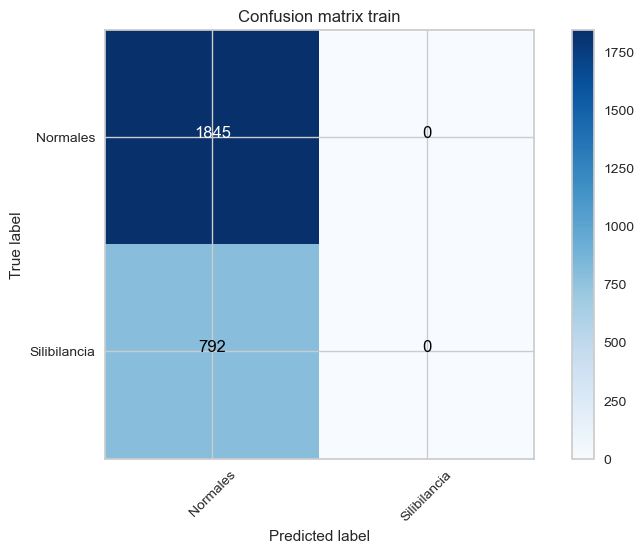

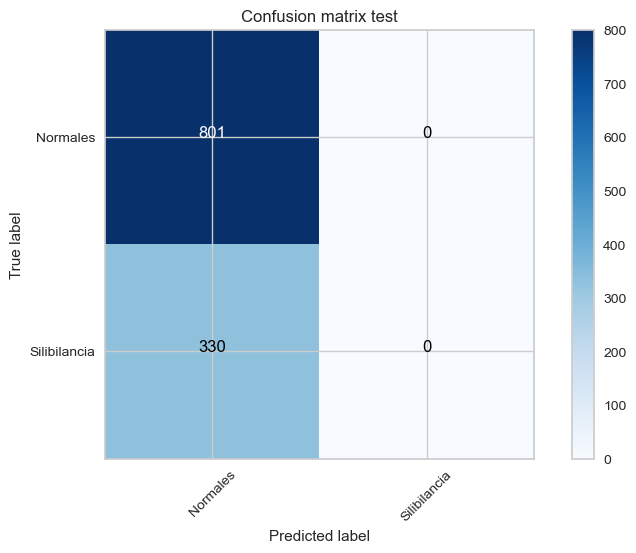

In [270]:
X_sn = df_sn[predictors].values
y_sn = df_sn[target_column].values #Normal o sibilante

#Se dividen los datos para entrenamiento, validación y prueba.
X_train_sn, X_test_sn, y_train_sn, y_test_sn = train_test_split(X_sn, y_sn, test_size=0.3, random_state=60)


y_test_sn = np.squeeze( y_test_sn)
y_train_sn = np.squeeze(y_train_sn)

mlp1 = MLPClassifier(hidden_layer_sizes=(4,4,4,4), activation='relu', solver='adam', max_iter=1000) 

Neural_architect(mlp1,X_train_sn,y_train_sn,X_test_sn,y_test_sn,target_names1)

Para crepitancias 

In [271]:
target_column = ['Estado del ciclo'] 
predictors = list(set(list(df_cn.columns))-set(target_column))
print(predictors)

#Sets are used to store multiple items in a single variable.
#Set is one of 4 built-in data types in Python used to store collections of data, 
#the other 3 are List, Tuple, and Dictionary, all with different qualities and usage.
#A set is a collection which is both unordered and unindexed.

#The variables are normalized
df_cn[predictors]=df_cn[predictors]/df_cn[predictors].max()
df_cn

['Sumatoria PSD', 'Varianza', 'Mediana PSD']


,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
3768,1.839620,1.432480,2.480512,2
3769,1.653834,1.336783,2.150446,2
3770,1.628538,1.323754,2.104923,2
3771,1.635951,1.327572,2.111957,2
3772,1.624738,1.321796,2.092743,2
...,...,...,...,...
2641,1.799975,1.412059,2.405002,0
2642,1.789782,1.406809,2.393183,0
2643,1.791733,1.407814,2.387519,0
2644,1.787591,1.405680,2.391480,0


In [272]:
X_cn = df_cn[predictors].values
y_cn = df_cn[target_column].values #Normal o crepitante

#Se dividen los datos para entrenamiento, validación y prueba.
X_train_cn, X_test_cn, y_train_cn, y_test_cn = train_test_split(X_cn, y_cn, test_size=0.3, random_state=60)


y_test_cn = np.squeeze(y_test_cn)
y_train_cn = np.squeeze(y_train_cn)

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1835    0]
 [1476    0]]
Confusion matrix, without normalization
[[1835    0]
 [1476    0]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.55      1.00      0.71      1835
 Crepitancia       0.00      0.00      0.00      1476

    accuracy                           0.55      3311
   macro avg       0.28      0.50      0.36      3311
weighted avg       0.31      0.55      0.40      3311

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[811   0]
 [608   0]]
Confusion matrix, without normalization
[[811   0]
 [608   0]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.57      1.00      0.73       811
 Crepitancia       0.00      0.00      0.00       608

    accuracy                           0.57      1419
   macro avg       0.29      0.50      0.36      1419
weighted avg       0.33      0.57      0.42      1419



c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


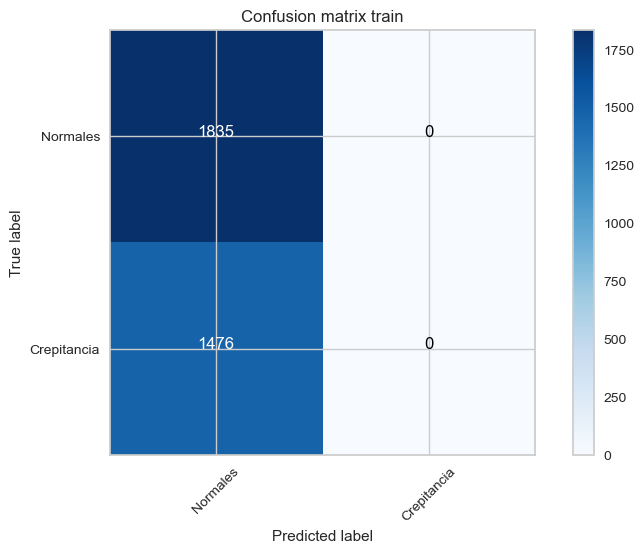

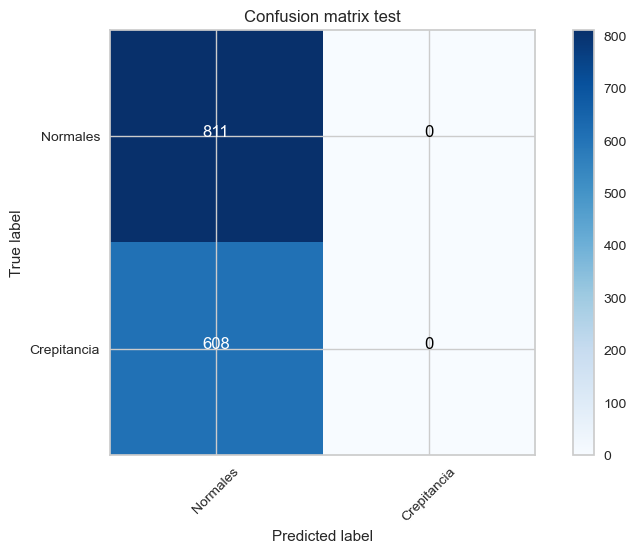

In [273]:

Neural_architect(mlp1,X_train_cn,y_train_cn,X_test_cn,y_test_cn,target_names2)

Para sibilancias-crepitancias

In [274]:
target_column = ['Estado del ciclo'] 
predictors = list(set(list(df_sc.columns))-set(target_column))
print(predictors)

#Sets are used to store multiple items in a single variable.
#Set is one of 4 built-in data types in Python used to store collections of data, 
#the other 3 are List, Tuple, and Dictionary, all with different qualities and usage.
#A set is a collection which is both unordered and unindexed.

#The variables are normalized
df_sc[predictors]=df_sc[predictors]/df_sc[predictors].max()
df_sc

['Sumatoria PSD', 'Varianza', 'Mediana PSD']


,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
3768,1.775516,1.406326,2.331509,2
3769,1.596203,1.312377,2.021270,2
3770,1.571789,1.299585,1.978481,2
3771,1.578944,1.303334,1.985093,2
3772,1.568121,1.297663,1.967033,2
...,...,...,...,...
3763,1.492075,1.257819,1.851946,1
3764,1.499447,1.261682,1.862725,1
3765,1.672475,1.352339,2.148464,1
3766,1.682609,1.357649,2.171169,1


In [275]:
X_sc = df_sc[predictors].values
y_sc = df_sc[target_column].values #Normal o sibilante

#Se dividen los datos para entrenamiento, validación y prueba.
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.3, random_state=60)


y_test_sc = np.squeeze(y_test_sc)
y_train_sc = np.squeeze(y_train_sc)

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[   0  785]
 [   0 1459]]
Confusion matrix, without normalization
[[   0  785]
 [   0 1459]]
-------------MÉTRICAS DE EVALUACIÓN-----------


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Sibilancia       0.00      0.00      0.00       785
 Crepitancia       0.65      1.00      0.79      1459

    accuracy                           0.65      2244
   macro avg       0.33      0.50      0.39      2244
weighted avg       0.42      0.65      0.51      2244

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[  0 337]
 [  0 625]]
Confusion matrix, without normalization
[[  0 337]
 [  0 625]]
-------------MÉTRICAS DE EVALUACIÓN-----------


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Sibilancia       0.00      0.00      0.00       337
 Crepitancia       0.65      1.00      0.79       625

    accuracy                           0.65       962
   macro avg       0.32      0.50      0.39       962
weighted avg       0.42      0.65      0.51       962



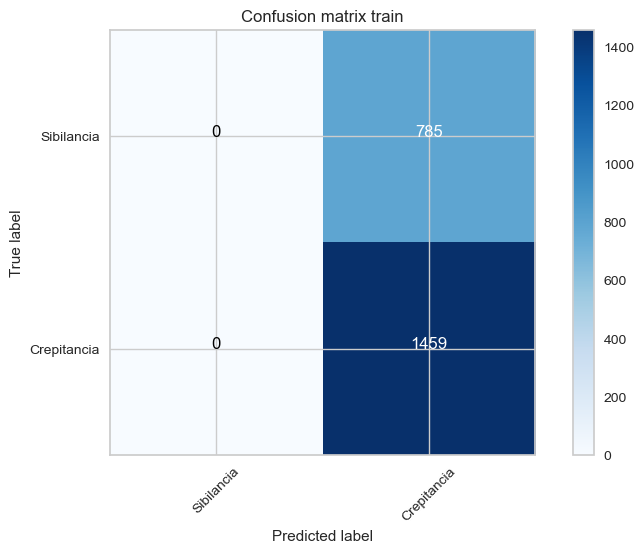

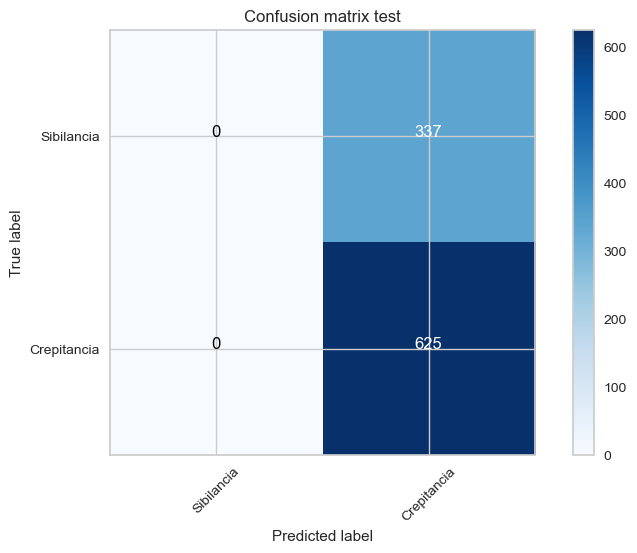

In [301]:
Neural_architect(mlp1,X_train_sc,y_train_sc,X_test_sc,y_test_sc,target_names3)

ARQUITECTURA 2

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1845    0]
 [ 792    0]]
Confusion matrix, without normalization
[[1845    0]
 [ 792    0]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.70      1.00      0.82      1845
Silibilancia       0.00      0.00      0.00       792

    accuracy                           0.70      2637
   macro avg       0.35      0.50      0.41      2637
weighted avg       0.49      0.70      0.58      2637

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[801   0]
 [330   0]]
Confusion matrix, without normalization
[[801   0]
 [330   0]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\skle

-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.71      1.00      0.83       801
Silibilancia       0.00      0.00      0.00       330

    accuracy                           0.71      1131
   macro avg       0.35      0.50      0.41      1131
weighted avg       0.50      0.71      0.59      1131



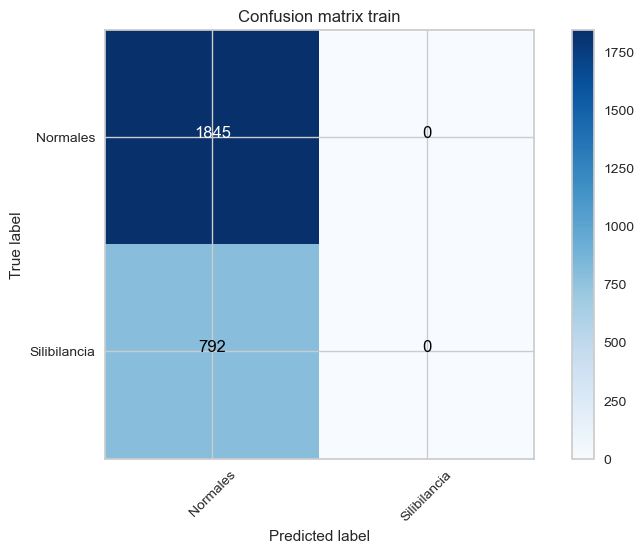

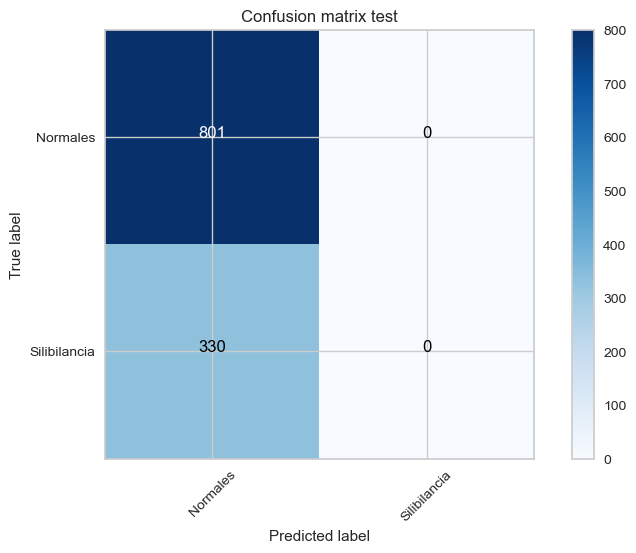

In [277]:
mlp2 = MLPClassifier(hidden_layer_sizes=(6,6,6,6), activation='relu', solver='adam', max_iter=10000) 
Neural_architect(mlp2,X_train_sn,y_train_sn,X_test_sn,y_test_sn,target_names1)

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1253  582]
 [ 745  731]]
Confusion matrix, without normalization
[[1253  582]
 [ 745  731]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.63      0.68      0.65      1835
 Crepitancia       0.56      0.50      0.52      1476

    accuracy                           0.60      3311
   macro avg       0.59      0.59      0.59      3311
weighted avg       0.60      0.60      0.60      3311

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[520 291]
 [323 285]]
Confusion matrix, without normalization
[[520 291]
 [323 285]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.62      0.64      0.63       811
 Crepitancia       0.49      0.47      0.48       608

    accuracy                           0.57      1419


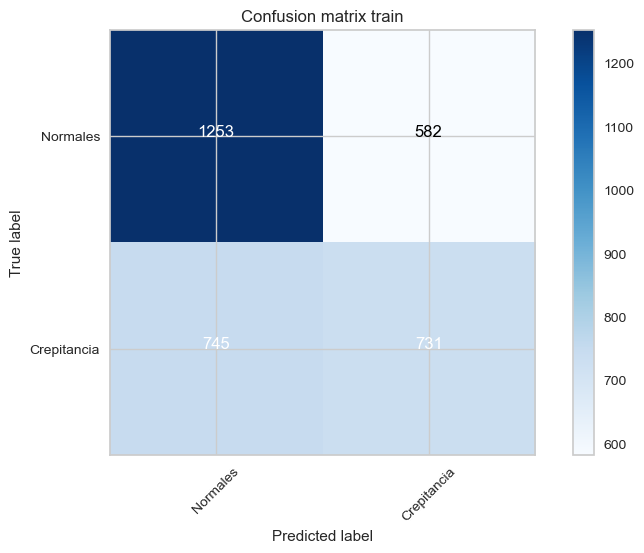

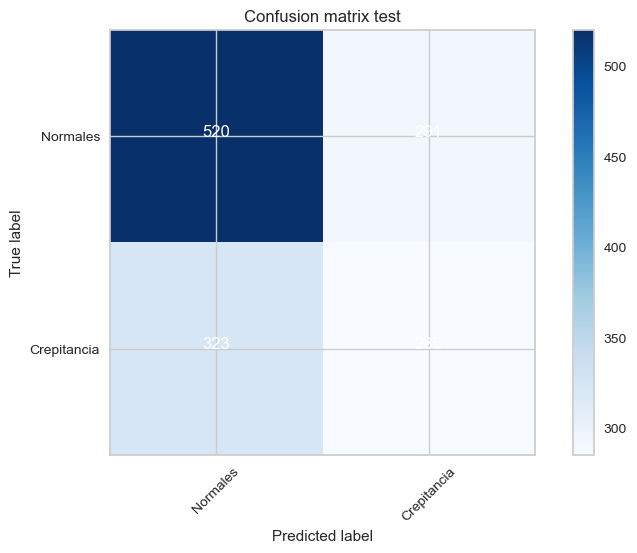

In [278]:
Neural_architect(mlp2,X_train_cn,y_train_cn,X_test_cn,y_test_cn,target_names2)



--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[   0  785]
 [   0 1459]]
Confusion matrix, without normalization
[[   0  785]
 [   0 1459]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

  Sibilancia       0.00      0.00      0.00       785
 Crepitancia       0.65      1.00      0.79      1459

    accuracy                           0.65      2244
   macro avg       0.33      0.50      0.39      2244
weighted avg       0.42      0.65      0.51      2244

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[  0 337]
 [  0 625]]
Confusion matrix, without normalization
[[  0 337]
 [  0 625]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

  Sibilancia       0.00      0.00      0.00       337
 Crepitancia       0.65      1.00      0.79       625

    accuracy                           0.65       962
   macro avg       0.32      0.50      0.39       962
weighted avg       0.42      0.65      0.51       962



c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


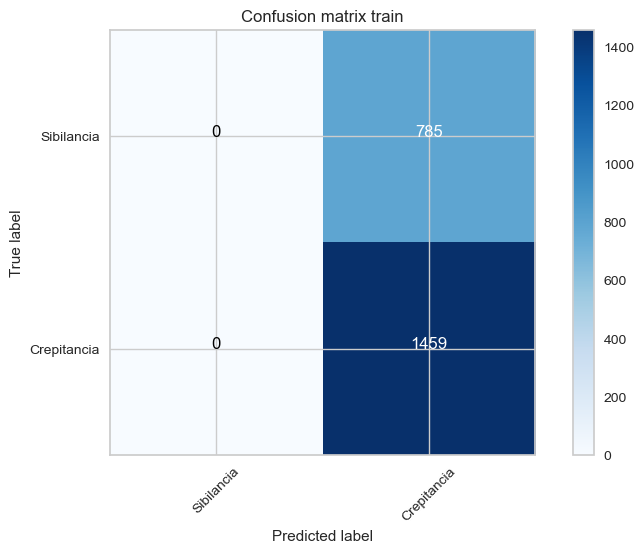

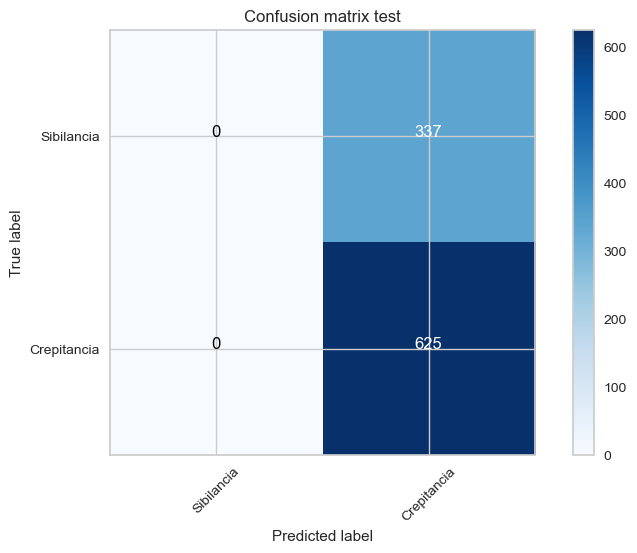

In [302]:
Neural_architect(mlp2,X_train_sc,y_train_sc,X_test_sc,y_test_sc,target_names3)

ARQUITECTURA 3

In [300]:
mlp3= MLPClassifier(hidden_layer_sizes=(20,20,20,20), activation='tanh', solver='lbfgs', max_iter=15000)
Neural_architect(mlp3,X_train_sn,y_train_sn,X_test_sn,y_test_sn,target_names1)


KeyboardInterrupt: 

c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1342  493]
 [ 657  819]]
Confusion matrix, without normalization
[[1342  493]
 [ 657  819]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.67      0.73      0.70      1835
 Crepitancia       0.62      0.55      0.59      1476

    accuracy                           0.65      3311
   macro avg       0.65      0.64      0.64      3311
weighted avg       0.65      0.65      0.65      3311

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[542 269]
 [297 311]]
Confusion matrix, without normalization
[[542 269]
 [297 311]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.65      0.67      0.66       811
 Crepitancia       0.54      0.51      0.52       608

    accuracy                           0.60      1419


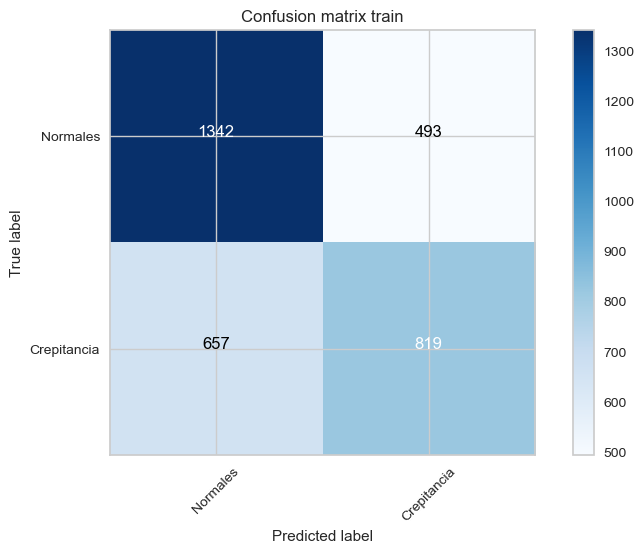

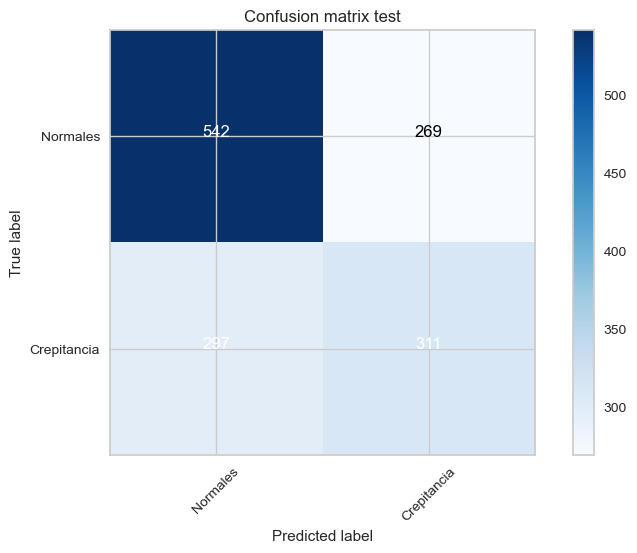

In [281]:
Neural_architect(mlp3,X_train_cn,y_train_cn,X_test_cn,y_test_cn,target_names2)

c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[ 181  604]
 [ 106 1353]]
Confusion matrix, without normalization
[[ 181  604]
 [ 106 1353]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

  Sibilancia       0.63      0.23      0.34       785
 Crepitancia       0.69      0.93      0.79      1459

    accuracy                           0.68      2244
   macro avg       0.66      0.58      0.56      2244
weighted avg       0.67      0.68      0.63      2244

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[ 57 280]
 [ 85 540]]
Confusion matrix, without normalization
[[ 57 280]
 [ 85 540]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

  Sibilancia       0.40      0.17      0.24       337
 Crepitancia       0.66      0.86      0.75       625

    accuracy                           0.62       962


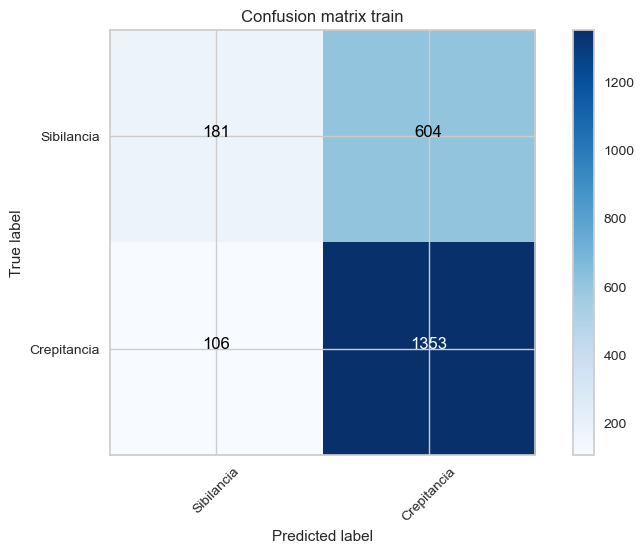

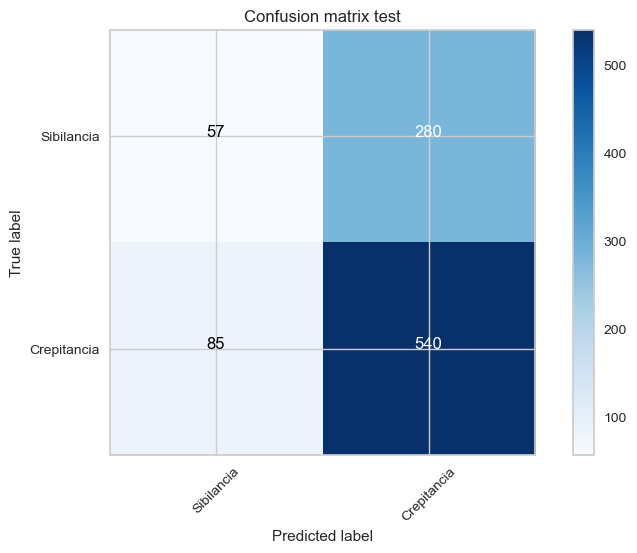

In [303]:
Neural_architect(mlp3,X_train_sc,y_train_sc,X_test_sc,y_test_sc,target_names3)

### f.  Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red (15%) y las matrices de confusión obtenidas (15%), de una red neuronal que permita la clasificación de ciclos normales, ciclos con crepitancias y ciclos con sibilancias

In [283]:
target_column = ['Estado del ciclo'] 
predictors = list(set(list(df_all.columns))-set(target_column))
print(predictors)

#Sets are used to store multiple items in a single variable.
#Set is one of 4 built-in data types in Python used to store collections of data, 
#the other 3 are List, Tuple, and Dictionary, all with different qualities and usage.
#A set is a collection which is both unordered and unindexed.

#The variables are normalized
df_all[predictors]=df_all[predictors]/df_all[predictors].max()
df_all

['Sumatoria PSD', 'Varianza', 'Mediana PSD']


,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
0,1.790208,1.407028,2.389996,0
1,1.793496,1.408722,2.385375,0
2,1.800257,1.412204,2.393050,0
3,1.793646,1.408799,2.387853,0
4,1.803711,1.413984,2.406521,0
...,...,...,...,...
5847,1.720170,1.370953,2.276454,2
5848,1.791727,1.407811,2.390649,2
5849,1.789511,1.406669,2.395744,2
5850,1.785067,1.404380,2.388639,2


In [284]:
X_all = df_all[predictors].values
y_all = df_all[target_column].values #Normal o crepitante

#Se dividen los datos para entrenamiento, validación y prueba.
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=60)


y_test_all = np.squeeze(y_test_all)
y_train_all = np.squeeze(y_train_all)

In [285]:
target_all=['Normales','Sibilancias','Crepitancias']

#### Arquitectura #1

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1331    0  522]
 [ 533    0  268]
 [ 857    0  585]]
Confusion matrix, without normalization
[[1331    0  522]
 [ 533    0  268]
 [ 857    0  585]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.49      0.72      0.58      1853
 Sibilancias       0.00      0.00      0.00       801
Crepitancias       0.43      0.41      0.42      1442

    accuracy                           0.47      4096
   macro avg       0.30      0.37      0.33      4096
weighted avg       0.37      0.47      0.41      4096

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[584   0 209]
 [211   0 110]
 [381   0 261]]
Confusion matrix, without normalization
[[584   0 209]
 [211   0 110]
 [381   0 261]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\skle

-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.50      0.74      0.59       793
 Sibilancias       0.00      0.00      0.00       321
Crepitancias       0.45      0.41      0.43       642

    accuracy                           0.48      1756
   macro avg       0.32      0.38      0.34      1756
weighted avg       0.39      0.48      0.42      1756



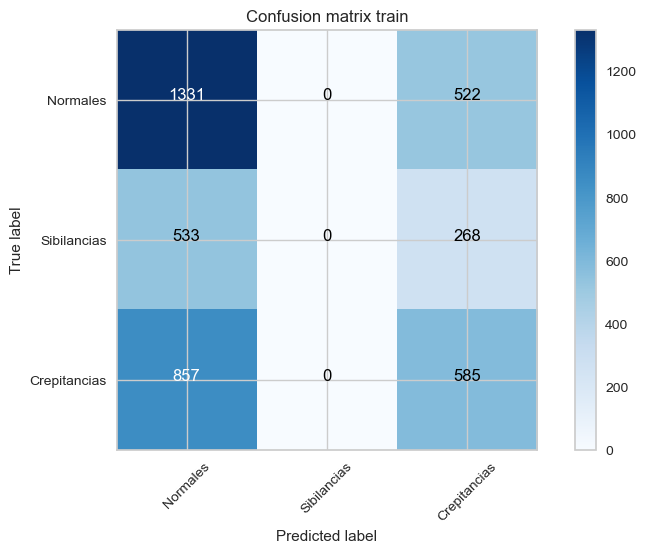

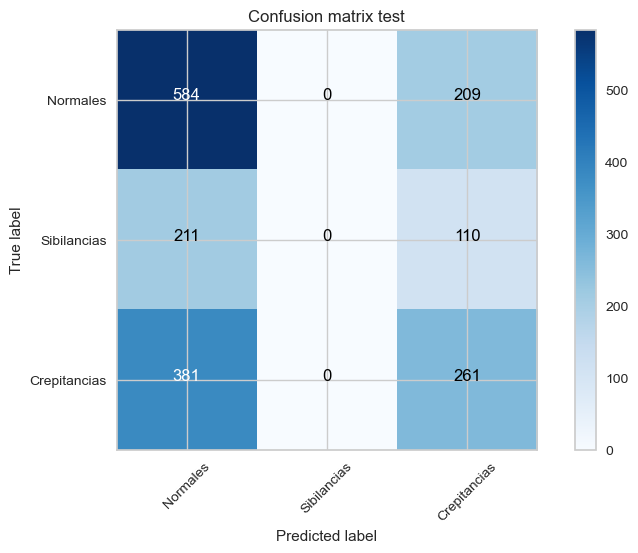

In [286]:
Neural_architect(mlp1,X_train_all,y_train_all,X_test_all,y_test_all,target_all)

#### Arquitectura #2

--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1212    0  641]
 [ 464    0  337]
 [ 715    0  727]]
Confusion matrix, without normalization
[[1212    0  641]
 [ 464    0  337]
 [ 715    0  727]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.51      0.65      0.57      1853
 Sibilancias       0.00      0.00      0.00       801
Crepitancias       0.43      0.50      0.46      1442

    accuracy                           0.47      4096
   macro avg       0.31      0.39      0.34      4096
weighted avg       0.38      0.47      0.42      4096

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[526   0 267]
 [177   0 144]
 [311   0 331]]
Confusion matrix, without normalization
[[526   0 267]
 [177   0 144]
 [311   0 331]]


c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.52      0.66      0.58       793
 Sibilancias       0.00      0.00      0.00       321
Crepitancias       0.45      0.52      0.48       642

    accuracy                           0.49      1756
   macro avg       0.32      0.39      0.35      1756
weighted avg       0.40      0.49      0.44      1756



c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


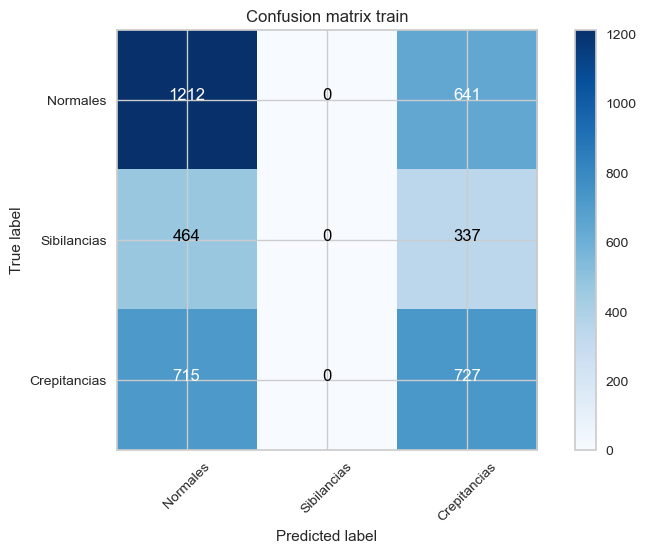

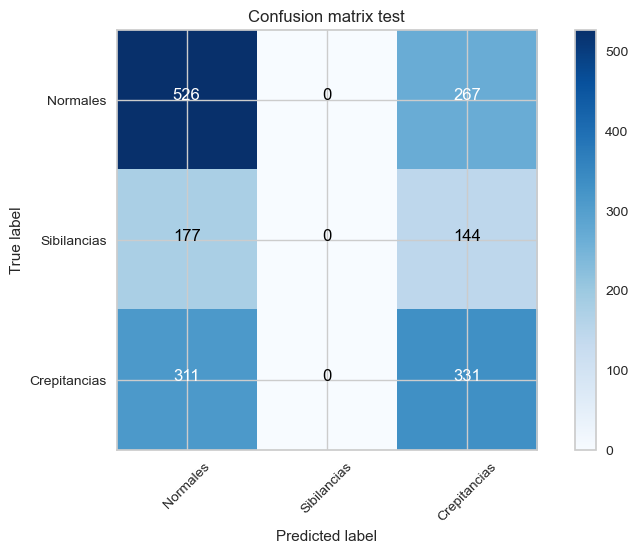

In [287]:
Neural_architect(mlp2,X_train_all,y_train_all,X_test_all,y_test_all,target_all)

#### Arquitectura #3

c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--------------CONJUNTO DE ENTRENAMIENTO----------
-------------MATRIZ DE CONFUSIÓN------------
[[1228    8  617]
 [ 411   13  377]
 [ 625   10  807]]
Confusion matrix, without normalization
[[1228    8  617]
 [ 411   13  377]
 [ 625   10  807]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Normales       0.54      0.66      0.60      1853
 Sibilancias       0.42      0.02      0.03       801
Crepitancias       0.45      0.56      0.50      1442

    accuracy                           0.50      4096
   macro avg       0.47      0.41      0.38      4096
weighted avg       0.49      0.50      0.45      4096

--------------CONJUNTO DE TEST----------
-------------MATRIZ DE CONFUSION------------
[[509   9 275]
 [166   5 150]
 [291   3 348]]
Confusion matrix, without normalization
[[509   9 275]
 [166   5 150]
 [291   3 348]]
-------------MÉTRICAS DE EVALUACIÓN-----------
              precision    recall  f1-score   support

    Nor

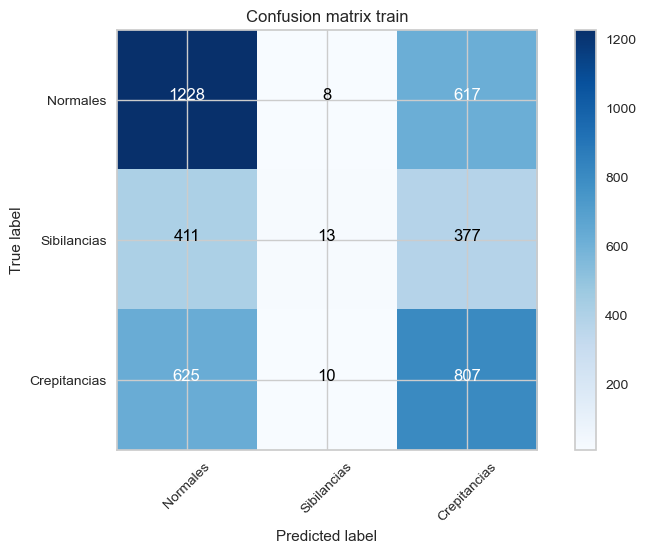

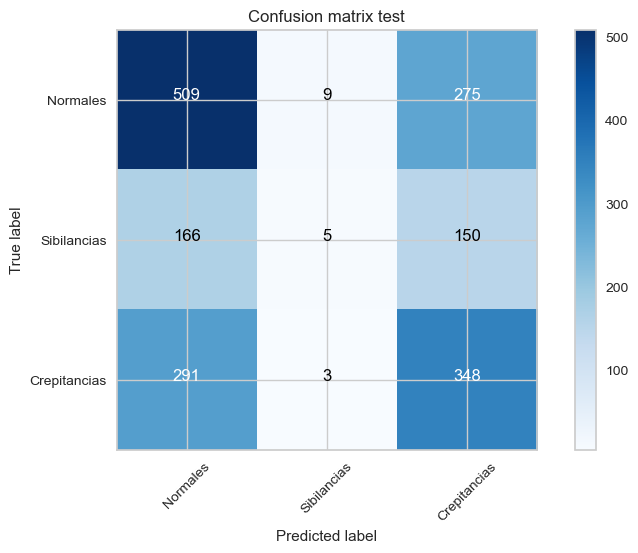

In [304]:
Neural_architect(mlp3,X_train_all,y_train_all,X_test_all,y_test_all,target_all)

### g.  Consultar cómo funciona, realizar y discutir un ejemplo con los datos de los ciclos respiratorios, del algoritmo de K means (10%) y máquinas de soporte vectorial (10%)


K-Means es un algoritmo no supervisado de Clustering iterativo y basado en prototipos en el que todos los puntos de datos se dividen en un número k de clústeres, cada uno de los cuales está representado por sus centroides. Se utiliza cuando se tiene gran cantidad de datos sin etiquetar. El objetivo de este algoritmo es el de encontrar “K” grupos (clusters) entre los datos 

El algoritmo trabaja iterativamente para asignar a cada “punto” (las filas del conjunto de entrada que forman una coordenada) uno de los “K” grupos basado en sus características. Son agrupados en base a la similitud de sus caracteristicas (las columnas).

El algoritmo K-Means cuenta con 3 pasos:
- Inicialización: Una vez escogido el número de grupos, se establecen k centroides en el espacio de los datos.
- Asignación: Cada objeto de los datos es asignado a su centroide más cercano.
- Actualización: Se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos.


Utilizando las 3 características elegidas anteriormente, se escoge el conjunto de datos con el que se usará el agrupamiento k

In [291]:
datosKmeans= df_all[['Sumatoria PSD','Mediana PSD','Varianza']]
datosKmeans

,Sumatoria PSD,Mediana PSD,Varianza
0,1.790208,1.407028,2.389996
1,1.793496,1.408722,2.385375
2,1.800257,1.412204,2.393050
3,1.793646,1.408799,2.387853
4,1.803711,1.413984,2.406521
...,...,...,...
5847,1.720170,1.370953,2.276454
5848,1.791727,1.407811,2.390649
5849,1.789511,1.406669,2.395744
5850,1.785067,1.404380,2.388639


Luego, se encuentra la cantidad óptima de grupos por medio del comando KElbow, el cual arrojará un número de clusters k óptimo para nuestro algoritmo.

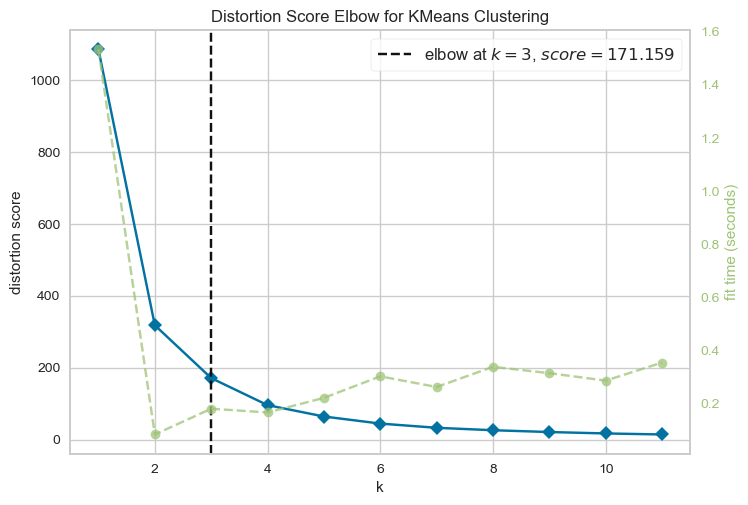

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [292]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(datosKmeans)
visualizer.show()

A continuación, en kmeans, n_clusters es el parámetro más importante y define el número de clústeres a formar. Otro parámetro importante es init, que define la inicialización del método a usar. El algoritmo k-means++ utiliza la técnica de siembra para la inicialización del centroide, que es mejor que el método de inicialización aleatoria 

In [293]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(datosKmeans)

In [294]:
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2])

In [295]:
kmeans.inertia_

171.18346723742616

In [296]:
from collections import Counter
Counter(kmeans.labels_)

Counter({2: 1511, 1: 2132, 0: 2209})

C:\Users\Esteban\AppData\Local\Temp\ipykernel_2952\426114067.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


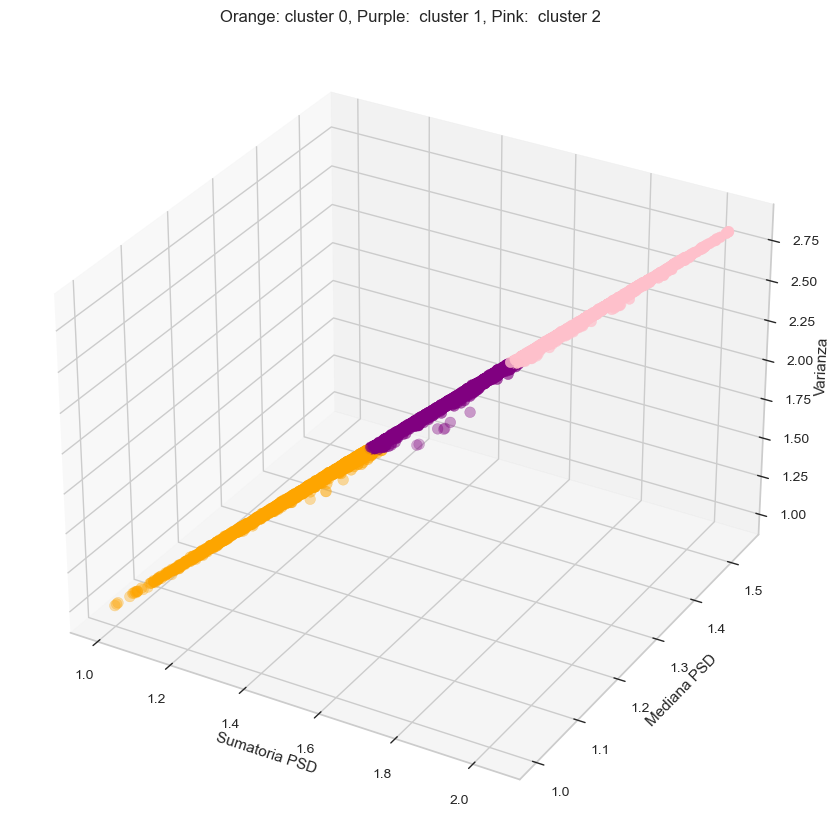

In [297]:
x = datosKmeans['Sumatoria PSD']
y = datosKmeans['Mediana PSD']
z = datosKmeans['Varianza']

labels = kmeans.labels_

#Centroide de los clusters. 
C = kmeans.cluster_centers_
colores=['orange','purple','pink']
asignar=[]
for row in labels:
    asignar.append(colores[row])


#Se plotea los tres grupos elegidos para diferenciar los tres clusters. 
fig = plt.figure(figsize=(15,8))
ax = Axes3D(fig)
ax.scatter(x, y, z, c=asignar,s=60)
plt.title('Orange: cluster 0, Purple:  cluster 1, Pink:  cluster 2')
ax.set_xlabel('Sumatoria PSD')
ax.set_ylabel('Mediana PSD')
ax.set_zlabel('Varianza')
plt.show()

Entrenamiento
              precision    recall  f1-score   support

    Normales       0.54      0.59      0.56      1853
 Sibilancias       0.00      0.00      0.00       801
Crepitancias       0.43      0.62      0.50      1442

    accuracy                           0.48      4096
   macro avg       0.32      0.40      0.36      4096
weighted avg       0.39      0.48      0.43      4096

Confusion matrix, without normalization
[[1091    0  762]
 [ 379    0  422]
 [ 555    0  887]]
-------------------------------------------------
Testeo
              precision    recall  f1-score   support

    Normales       0.55      0.59      0.57       793
 Sibilancias       0.00      0.00      0.00       321
Crepitancias       0.45      0.62      0.52       642

    accuracy                           0.49      1756
   macro avg       0.33      0.40      0.36      1756
weighted avg       0.41      0.49      0.45      1756

Confusion matrix, without normalization
[[468   0 325]
 [146   0 175]
 [

c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Esteban\anaconda3\lib\site-packages\skle

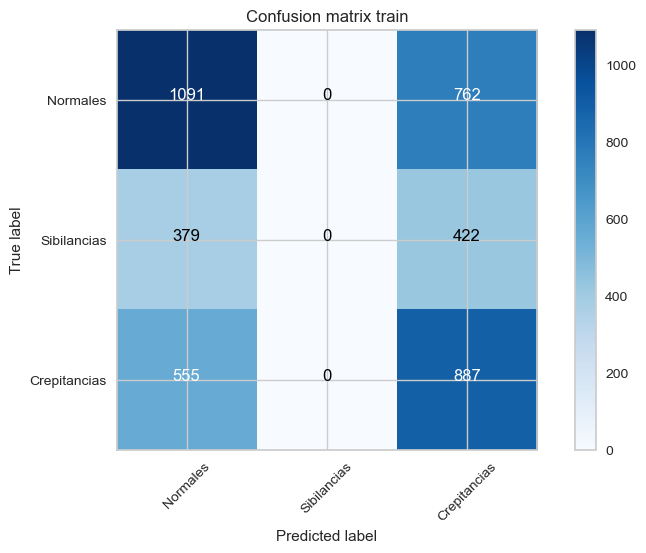

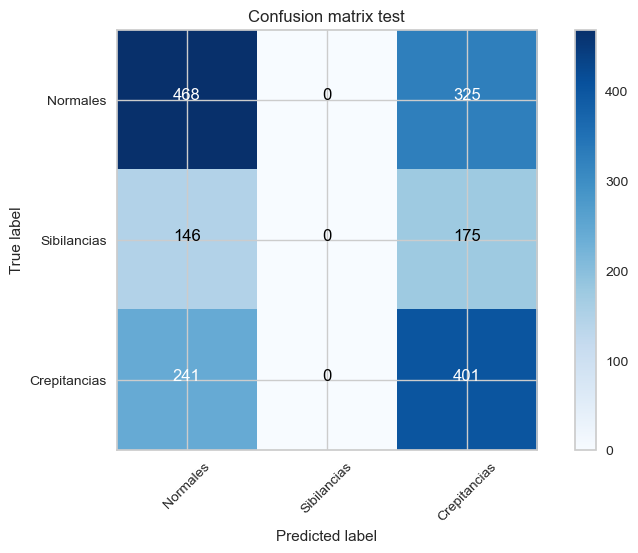

In [298]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=100)
clf.fit(X_train_all, y_train_all)
predict_train_all_svm = clf.predict(X_train_all)
predict_test_all_svm = clf.predict(X_test_all)

print("Entrenamiento")
print(classification_report(y_train_all,predict_train_all_svm,target_names=['Normales','Sibilancias','Crepitancias']))
cm = confusion_matrix(y_train_all, predict_train_all_svm)
plot_confusion_matrix(cm, classes=target_all,
                      title='Confusion matrix train')

print("-------------------------------------------------")
print("Testeo")
print(classification_report(y_test_all,predict_test_all_svm,target_names=['Normales','Sibilancias','Crepitancias']))
cm = confusion_matrix(y_test_all,predict_test_all_svm)
plot_confusion_matrix(cm, classes=target_all,
                      title='Confusion matrix test')
plt.show()